**Chapter 9 – Unsupervised Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 9._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
%env OMP_NUM_THREADS=4
%env MKL_NUM_THREADS=4

env: OMP_NUM_THREADS=4
env: MKL_NUM_THREADS=4


In [2]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/unsupervised_learning` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

# Clustering

**Introduction – Classification _vs_ Clustering**

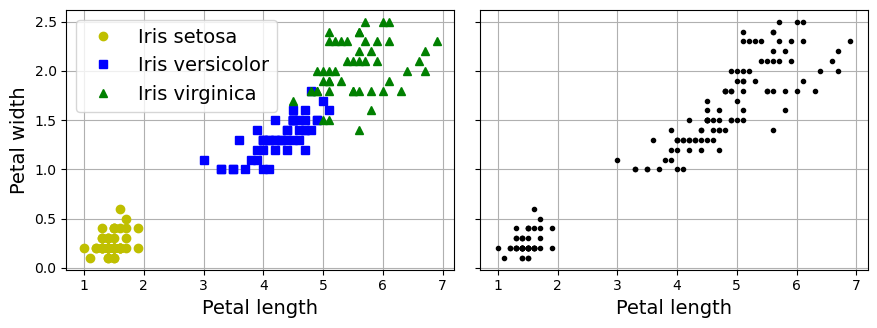

In [6]:
# extra code – this cell generates and saves Figure 9–1

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
#X[y==0, 2]->Toma todas las filas de X donde y == 0 (es decir, las flores setosa) y selecciona la columna 2 (longitud del pétalo)->eje X
#X[y==0, 3] →Toma todas las filas de X donde y == 0 (es decir, las flores setosa) y selecciona la columna 3 (anchura del pétalo)-> eje y

plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)#No mostrar las etiquetas numéricas del eje Y
plt.gca().set_axisbelow(True)#gca=obeteenr el eje actual (get current axes). set_axisbelow(True)->la rejilla la pone por debajo de los puntos, para que se vean
plt.grid()

save_fig("classification_vs_clustering_plot")
plt.show()

**Note**: the next cell shows how a Gaussian mixture model (explained later in this chapter) can actually separate these clusters pretty well using all 4 features: petal length & width, and sepal length & width. This code maps each cluster to a class. Instead of hard coding the mapping, the code picks the most common class for each cluster using the `scipy.stats.mode()` function:

C:\Users\srmjf\anaconda3\envs\geron\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


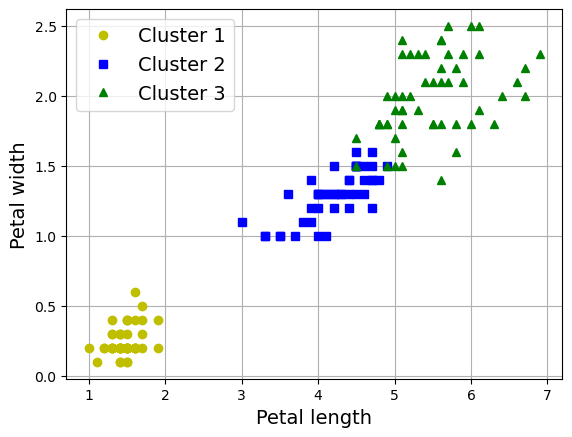

In [7]:
# extra code

import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

What's the ratio of iris plants we assigned to the right cluster?

In [8]:
(y_pred==y).sum() / len(y_pred)

np.float64(0.9666666666666667)

## K-Means

**Fit and predict**

Let's train a K-Means clusterer on a dataset if blobs. It will try to find each blob's center and assign each instance to the closest blob:

In [9]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

# Esto es lo importante ahora
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Note: Throughout this notebook, when `n_init` was not set when creating a `KMeans` estimator, I explicitly set it to `n_init=10` to avoid a warning about the fact that the default value for this hyperparameter will change from 10 to `"auto"` in Scikit-Learn 1.4.

Now let's plot them:

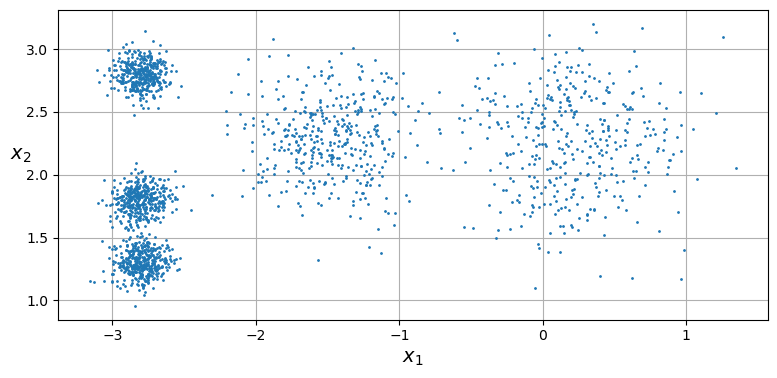

In [10]:
# extra code – this cell generates and saves Figure 9–2

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

Each instance was assigned to one of the 5 clusters:

In [11]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [12]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [13]:
kmeans.cluster_centers_ # para ver los centroides

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to (they are not targets, they are predictions):

In [14]:
kmeans.labels_
#Este atributo contiene las etiquetas asignadas (a qué cluster pertenece) a cada punto del conjunto de entrenamiento (X).

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [15]:
len(kmeans.labels_)


2000

Of course, we can predict the labels of new instances:

In [16]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

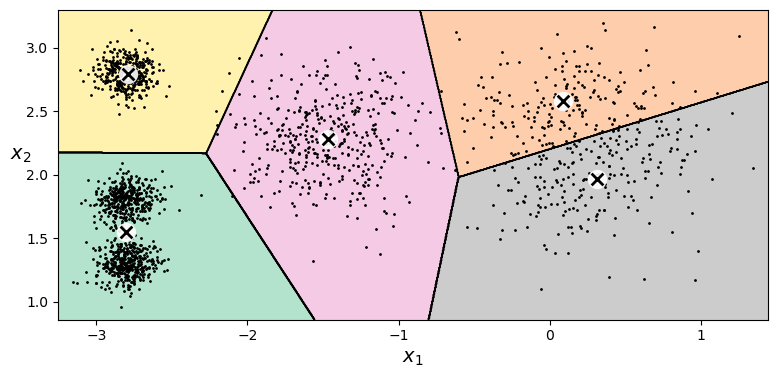

In [17]:
# extra code – this cell generates and saves Figure 9–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering _vs_ Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better to measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [18]:
kmeans.transform(X_new).round(2)
# Mide la distancia de cada instancia hasta cada centroide

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [19]:
# extra code
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)
#np.tile-> Repite el contenido de X_new k veces en horizontal.
#Esto se hace para preparar la estructura que luego se comparará con los k centroides.
#.reshape(-1, k, 2) -> reorganiza esa matriz en 3 dimensiones:

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`. More on this later in this chapter.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

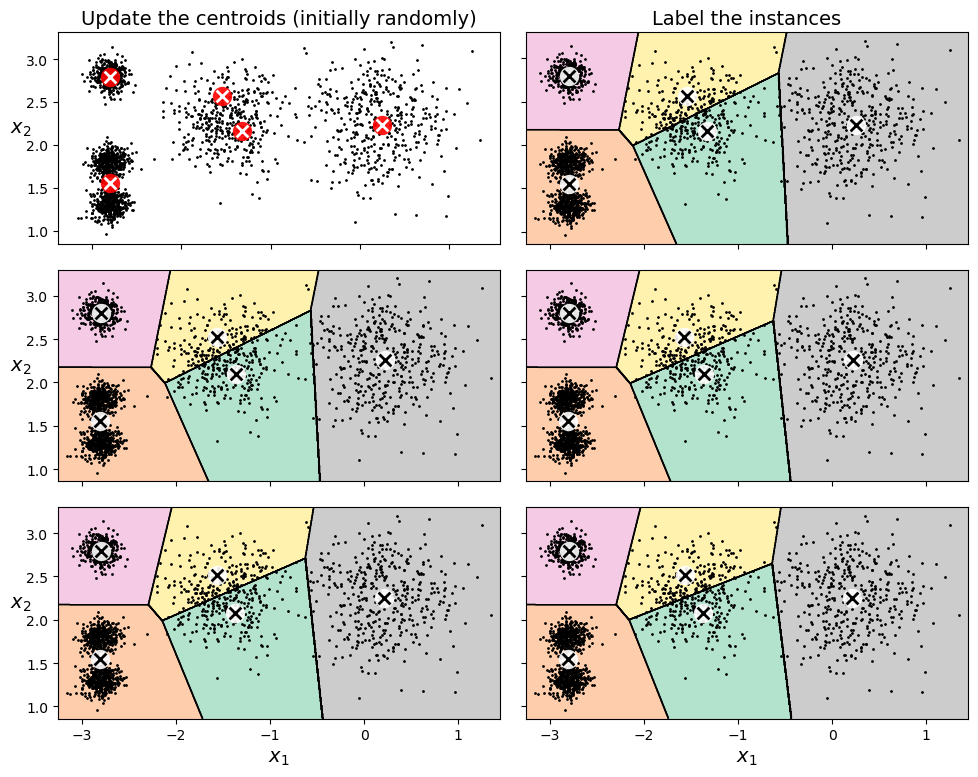

In [20]:
# extra code – this cell generates and saves Figure 9–4

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

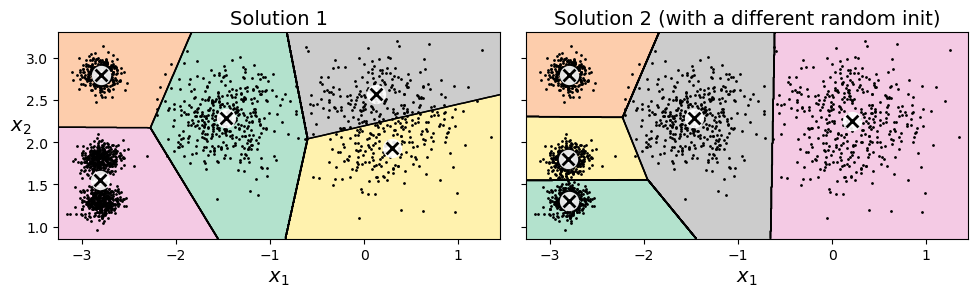

In [21]:
# extra code – this cell generates and saves Figure 9–5

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

In [22]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

,n_clusters,5
,init,"array([[-3, ... [ 0, 2]])"
,n_init,1
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


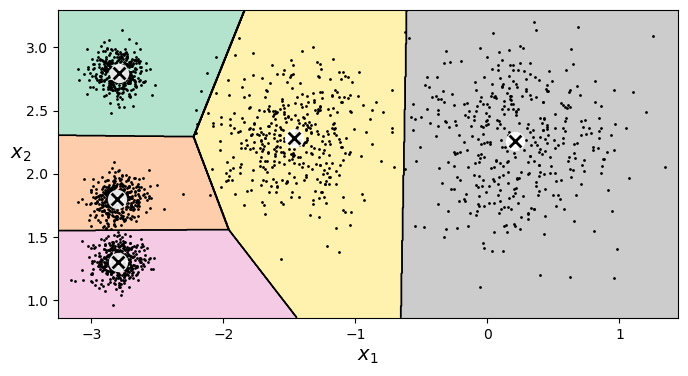

In [23]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [24]:
kmeans.inertia_

211.59853725816836

In [25]:
kmeans_rnd_init1.inertia_  # extra code

219.5820150360229

In [26]:
kmeans_rnd_init2.inertia_  # extra code

211.59853725816836

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [27]:
# extra code
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

np.float64(211.59853725816856)

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [28]:
kmeans.score(X)

-211.59853725816834

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [29]:
# extra code
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

,n_clusters,5
,init,'random'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,2
,copy_x,True
,algorithm,'lloyd'


As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

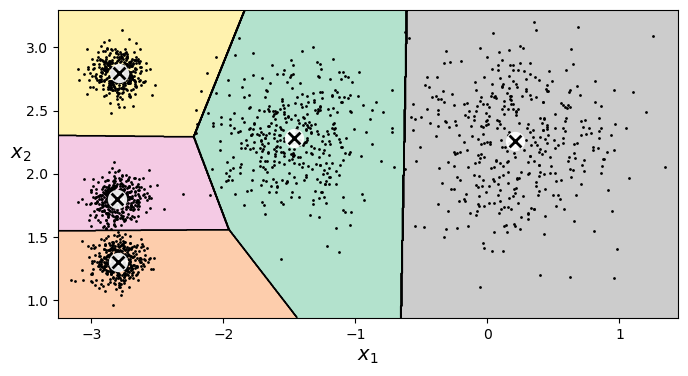

In [30]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [31]:
kmeans_rnd_10_inits.inertia_

211.59853725816836

### Centroid initialization methods

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

### Accelerated K-Means

The K-Means algorithm can sometimes be accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

For Elkan's variant of K-Means, use `algorithm="elkan"`. For regular KMeans, use `algorithm="full"`. The default is `"auto"`, which uses the full algorithm since Scikit-Learn 1.1 (it used Elkan's algorithm before that).

### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [32]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
minibatch_kmeans.fit(X)

,n_clusters,5
,init,'k-means++'
,max_iter,100
,batch_size,1024
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,3


Note: Throughout this notebook, when `n_init` was not set when creating a `MiniBatchKMeans` estimator, I explicitly set it to `n_init=3` to avoid a warning about the fact that the default value for this hyperparameter will change from 3 to `"auto"` in Scikit-Learn 1.4.

In [33]:
minibatch_kmeans.inertia_

211.658993745743

**Using `MiniBatchKMeans` along with `memmap`** (not in the book)

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [34]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")

Let's split the dataset:

In [35]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

Next, let's write the training set to a `memmap`:

In [36]:
filename = "my_mnist.mmap" #l nombre del archivo donde se guardarán los datos
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                     shape=X_train.shape)
#dtype='float32' → tipo de dato (igual al de X_train).
#mode='write' → abrir el archivo para escritura (crear o sobrescribir).
#shape=X_train.shape → reserva el mismo tamaño que el dataset original.
#En este punto el archivo my_mnist.mmap se crea en disco, pero no contiene todavía los datos de X_train.
X_memmap[:] = X_train #Esto copia los datos de X_train al archivo mapeado. 
                    #Es decir cada número de X_train se escribe directamente en el archivo binario, sin mantener todo en RAM a la vez.
                    # Si X_train es grande, NumPy lo copia por bloques internamente.
X_memmap.flush() #Guarda (“flushea”) los datos pendientes al disco ->Hasta aquí el archivo my_mnist.mmap ya contiene permanentemente los datos de X_train.

In [37]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                   n_init=3, random_state=42)
minibatch_kmeans.fit(X_memmap)

C:\Users\srmjf\anaconda3\envs\geron\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


,n_clusters,10
,init,'k-means++'
,max_iter,100
,batch_size,10
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,3


Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

100/100

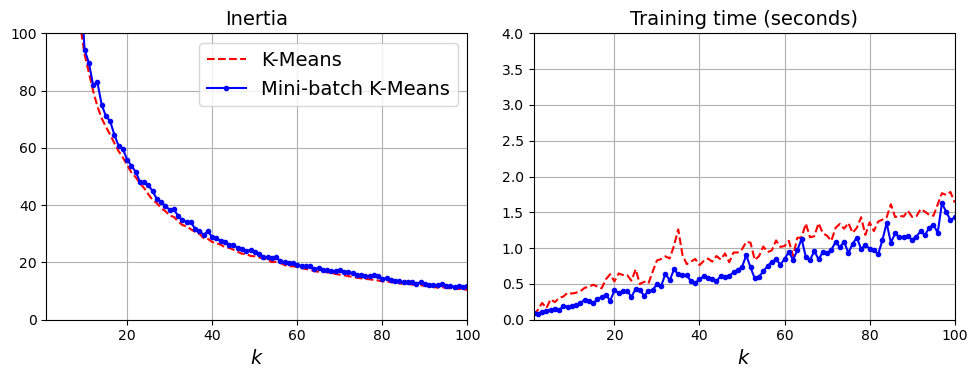

In [38]:
# extra code – this cell generates and saves Figure 9–6
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=k,
    n_init=10,
    random_state=42,
    batch_size=4096   # >= 2048 evita el warning
)


from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

save_fig("minibatch_kmeans_vs_kmeans_plot")
plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

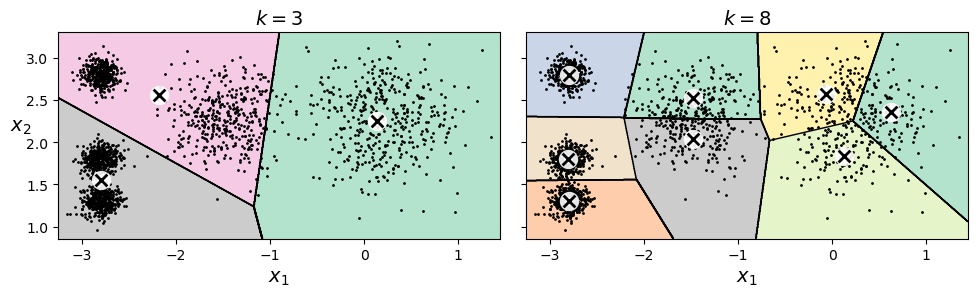

In [39]:
# extra code – this cell generates and saves Figure 9–7

kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [40]:
kmeans_k3.inertia_

653.2167190021552

In [41]:
kmeans_k8.inertia_

119.22484592677117

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

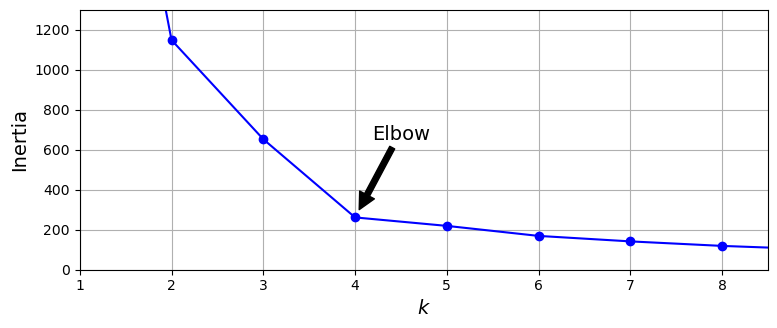

In [42]:
# extra code – this cell generates and saves Figure 9–8
# Regla del codo

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)] #Entrena 9 modelos de K-Means, con k (número de clusters) variando de 1 a 9

#Es lo mismo que
'''
kmeans_per_k = []
for k in range(1, 10):
    modelo = KMeans(n_clusters=k, n_init=10, random_state=42)
    modelo.fit(X)
    kmeans_per_k.append(modelo)'''

inertias = [model.inertia_ for model in kmeans_per_k]
# es lo mismo que
'''
inertias = []
for modelo in kmeans_per_k:
    inertias.append(modelo.inertia_)
    '''

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

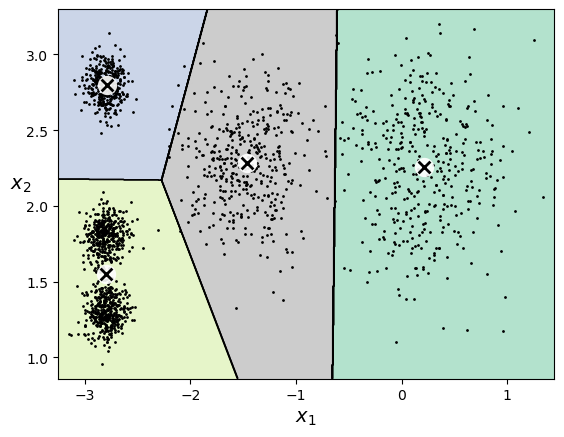

In [43]:
# extra code
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to (_b_ - _a_) / max(_a_, _b_) where _a_ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and _b_ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes _b_, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [44]:
from sklearn.metrics import silhouette_score

In [45]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

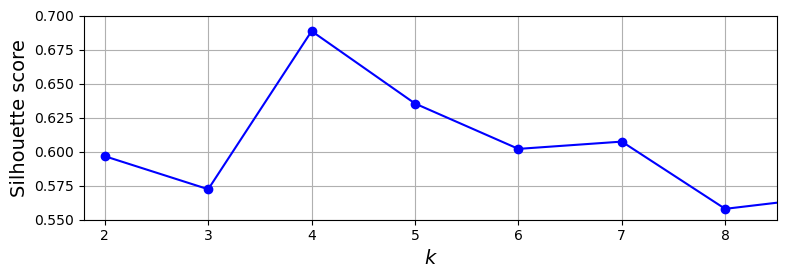

In [46]:
# extra code – this cell generates and saves Figure 9–9

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
#Hacemos k[1:] porque al calcular la formula de la silueta no hay otro cluster para calcular la diferencia b (diferencia al otro cluster). s=(b−a)/max(a,b) 
#De otra manera daría error
#sería equivalente a 
'''
silhouette_scores =[]
for model in kmeans_per_K[1:]:
    silueta= silhouette_score(X, model,labels_)
    silhouette_scores.append(silueta)
    '''


plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

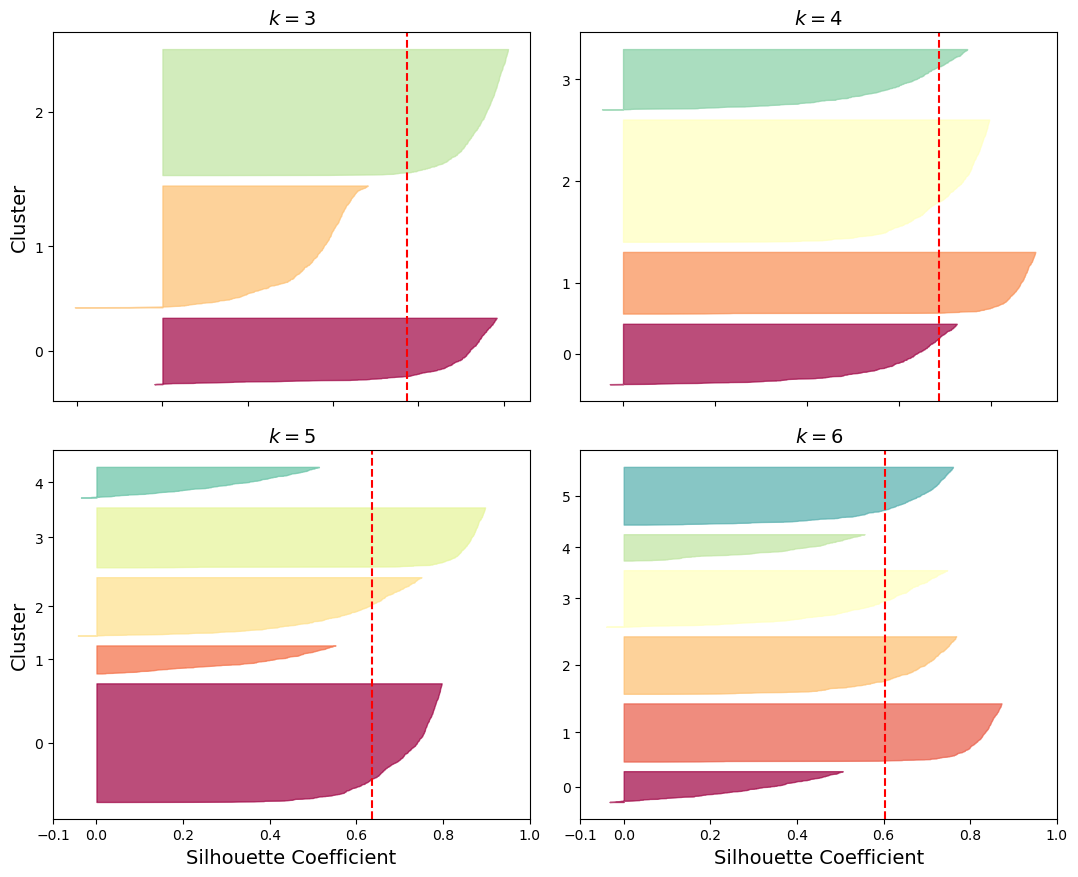

In [47]:
# extra code – this cell generates and saves Figure 9–10

#Diagrama de silueta

from sklearn.metrics import silhouette_samples #devuelve un valor de silueta por muestra (no la media). Con eso dibujas el diagrama de silueta “de barras apiladas”.
from matplotlib.ticker import FixedLocator, FixedFormatter#e dejan forzar dónde van las marcas del eje Y y qué texto muestran (aquí, los índices de cluster 0..k-1 en posiciones concretas).

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2) #usa índice 1-basado:k=3 → idx=1 (arriba-izquierda); k=4 → idx=2 (arriba-derecha);k=5 → idx=3 (abajo-izquierda);k=6 → idx=4 (abajo-derecha)
    
    y_pred = kmeans_per_k[k - 1].labels_
    #kmeans_per_k es tu lista de modelos entrenados con k=1..9 (índice 0..8). Por eso para k actual tomas k-1.
    silhouette_coefficients = silhouette_samples(X, y_pred)
    #silhouette_coefficients tiene la misma longitud que X; cada entrada ∈ [-1, 1]:
        #Cerca de 1 → punto muy bien incrustado en su cluster.
        #Cerca de 0 → en el borde.
        #Negativo → probablemente mal asignado.

    padding = len(X) // 30 #añade aire entre bandas.
    pos = padding #es el índice Y donde empieza la banda del cluster actual.
    ticks = [] #guardará el centro vertical de cada banda para etiquetar el eje Y.
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i] #selecciona las siluetas solo del cluster i.
        coeffs.sort() #ordena de menor a mayor → la banda queda “suave” visualmente (de valores pequeños a grandes).

        color = plt.cm.Spectral(i / k) #elige un color distinto por cluster (i/k ∈ [0,1)). Spectral es un colormap que recorre una gama de colores (azul → verde → amarillo → rojo).Cuando le pasas un número entre 0 y 1, te devuelve un color en formato RGBA (red, green, blue, alpha).
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        #fill_betweenx(y, x1, x2): rellena horizontalmente desde x=0 hasta x=coeffs[j] para cada “fila y”. Resultado: una banda cuya anchura codifica el valor de silueta.
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    #mis marcas mayores estarán en ticks (centros de cada banda)
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

## Limits of K-Means

Let's generate a more difficult dataset, with elongated blobs and varying densities, and show that K-Means struggles to cluster it correctly:

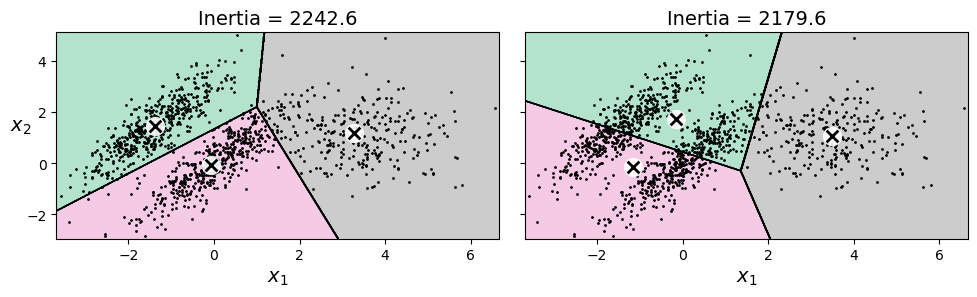

In [48]:
# extra code – this cell generates and saves Figure 9–11

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")

save_fig("bad_kmeans_plot")
plt.show()

## Using Clustering for Image Segmentation

Download the ladybug image:

In [49]:
# extra code – downloads the ladybug image

import urllib.request

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [50]:
# Paquete Pillow (PIL = Python Imaging Library)-> Sirve para abrir, manipular y guardar imágenes en distintos formatos (JPG, PNG, etc.)
import PIL

image = np.asarray(PIL.Image.open(filepath))
#PIL.Image.open(filepath) -> Abre una imagen desde un archivo
#np.asarray(...) -> La convierte en un array NumPy
image.shape #Te dice sus dimensiones (alto, ancho, canales)

(533, 800, 3)

significa:

533 → altura (número de filas, o píxeles verticales)

800 → anchura (número de columnas, o píxeles horizontales)

3 → número de canales de color

📘 ¿Qué son los canales?

Los canales representan la intensidad de cada componente de color en cada píxel.
En una imagen RGB (la más común), hay 3 canales:

Canal	Significado	Rango típico
0	Rojo (Red)	0–255
1	Verde (Green)	0–255
2	Azul (Blue)	0–255

Cada píxel, por tanto, no tiene un único valor, sino un vector de tres valores (R, G, B).
Por ejemplo, el píxel [255, 0, 0] sería rojo puro, mientras que [0, 0, 255] sería azul puro.

💡 Otros ejemplos

Imagen en escala de grises → solo tiene 1 canal (shape: (533, 800) o (533, 800, 1)).

Imagen RGBA → tiene 4 canales (Red, Green, Blue y Alpha, donde Alpha es la transparencia → (533, 800, 4)).

Importante-> Cada “celda” o posición [fila, columna] del array representa un píxel, y ese píxel no tiene un único valor, sino un vector de tres números que indican cuánta intensidad hay de cada color primario:

pixel[fila,columna]=[R,G,B]

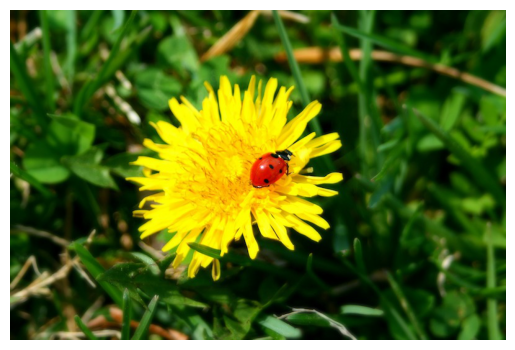

In [52]:
# Para visualizar la imagen con Matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.show()


In [53]:
X = image.reshape(-1, 3)
#Pasamos a tener n filas y 3 columnas (Canal R, Canal G y Canal B)
#El -1 le dice a NumPy: “Calcula automáticamente cuántas filas hay en total, según el tamaño total del array y las 3 columnas que quiero mantener”. -> se aplanan todas las filas y columnas en una sola lista larga de píxeles.
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X) #Entrenamos un modelo de K-Means con los datos X, donde cada fila representa un píxel (R, G, B). Encuentra 8 centroides y asigna, en un array 1D (kmeans.labels) a cada pixel una etiqueta de 0 a 7
# Buscamos 8 grupos de color
#n_init=10 -> Ejecuta K-Means 10 veces con diferentes inicializaciones de los centroides, y se queda con la mejor.
segmented_img = kmeans.cluster_centers_[kmeans.labels_] 
# kmeans.cluster_centers_ ->obtiene los 8 colores promedio de los grupos (cada uno es un vector [R, G, B]).Los centroides de los clusters. Forma (8,3)
# kmeans.labels_ → indica, para cada píxel, a qué grupo pertenece (un número de 0 a 7).. Forma (426400,) Una etiqueta por píxel
# kmeans.cluster_centers_[kmeans.labels_] -> Usa esa etiqueta para sustituir cada píxel por el color del centroide.

segmented_img = segmented_img.reshape(image.shape)

Por partes...

In [55]:
kmeans.cluster_centers_

array([[  5.6105612 ,  27.61743918,   1.44857047],
       [250.68280046, 237.8319458 ,   6.51237711],
       [ 54.37997208,  97.09151272,  14.07131629],
       [155.1122467 , 160.29920705,  98.37997063],
       [ 93.53208815, 132.47927103,  39.06947451],
       [ 24.39502109,  63.41611633,   4.09118396],
       [195.12454743,  50.81607531,  11.20057929],
       [223.40683449, 182.94424185,   9.39848253]])

In [56]:
kmeans.labels_

array([0, 0, 0, ..., 5, 5, 0], dtype=int32)

In [58]:
kmeans.cluster_centers_[kmeans.labels_] #Ha usado las etiquetas (labels_) como índices para elegir, en cada caso, la fila correspondiente del array cluster_centers_.

array([[ 5.6105612 , 27.61743918,  1.44857047],
       [ 5.6105612 , 27.61743918,  1.44857047],
       [ 5.6105612 , 27.61743918,  1.44857047],
       ...,
       [24.39502109, 63.41611633,  4.09118396],
       [24.39502109, 63.41611633,  4.09118396],
       [ 5.6105612 , 27.61743918,  1.44857047]])

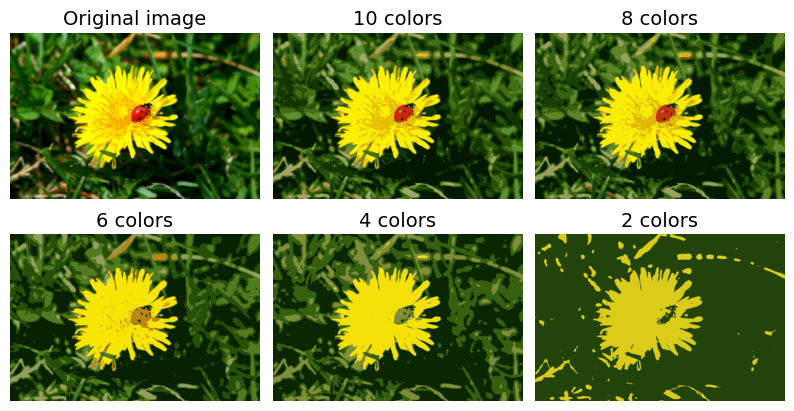

In [59]:
# extra code – this cell generates and saves Figure 9–12

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

save_fig('image_segmentation_plot', tight_layout=False)
plt.show()

## Using Clustering for Semi-Supervised Learning

Another use case for clustering is semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [60]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [63]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [64]:
log_reg.score(X_test, y_test) #medimos la exactitud del modelo

0.7581863979848866

In [65]:
# extra code – measure the accuracy when we use the whole training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

Usemos K-Means para encontrar 50 grupos de datos similares, y de cada grupo elijamos un ejemplo representativo. Así obtengo un conjunto de ejemplos muy diversos

In [67]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
#.fit_transform() entrena K-Means y además devuelve una matriz de distancias.
    #Cada fila corresponde a una muestra del conjunto de entrenamiento.
    #Cada columna corresponde a un centroide (de los 50).
    #X_digits_dist tiene forma (n_muestras, 50)
    #Cada celda [i, j] es la distancia de la muestra i al centroide j.
representative_digit_idx = X_digits_dist.argmin(axis=0)
#argmin(axis=0) busca, para cada columna (cada clúster),el índice de la muestra más cercana a su centroide. para cada culter hasta el 49 - forma (50,)
X_representative_digits = X_train[representative_digit_idx]
#Ahora tomas esas 50 muestras del dataset original. -> (50, n)

Now let's plot these representative images and label them manually:

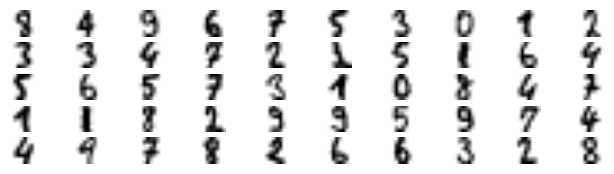

In [68]:
# extra code – this cell generates and saves Figure 9–13

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

In [73]:
# Nos fijamos en las 50 imágenes y las etiquetamos manualmente

y_representative_digits = np.array([
    8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
    3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
    5, 6, 5, 7, 3, 1, 0, 8, 4, 7,
    1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
    4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

In [74]:
y_representative_digits.shape

(50,)

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [75]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

Wow! We jumped from 74.8% accuracy to 84.9%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

Propagación de etiquetas

In [76]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
#Crea un array vacío con el mismo número de elementos que X_train
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]
    #kmeans.labels_ == i produce un array de valores booleanos (True o False) del mismo tamaño que y_train_propagated.
    #al ponerlo entre corchetes sólo selecciono lo que es True

In [77]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [78]:
log_reg.score(X_test, y_test)

0.8589420654911839

We got another significant accuracy boost! Let's see if we can do even better by ignoring the 1% instances that are farthest from their cluster center: this should eliminate some outliers:

Eliminamos valores atípicos: ignoramos el 1% de las instancias que están más lejos del centro de su grupo

Vas a quedarte con el 99% más cercano al centroide dentro de cada clúster (y descartar el 1% más lejano = sospechosos/outliers/borde).


In [79]:
percentile_closest = 99

#importante: 
    #hasta ahora: X_digits_dist.shape tiene esta forma (n_muestras, k) donde cada de celda es la distancia de la muestra a su centroide.
    #Ahora queremos es tener una sola distancia por muestra (no k)


X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

# NumPy coge para fila i la columna indicada la columna kmeans.labels_[i] -> Para la muestra i, dame su distancia al centroide que le corresponde.
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest) #Calcula el percentil 99 de las distancias dentro de ese clúster.
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1 #si está en ese cluster y es supeior al percentil 99 le asignas -1

partially_propagated = (X_cluster_dist != -1) #para quedarse solo con los buenos (no -1) y descartar los sospechosos antes de reentrenar el modelo.
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [80]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8564231738035264

Wow, another accuracy boost! We have even slightly surpassed the performance we got by training on the fully labeled training set!

Our propagated labels are actually pretty good: their accuracy is about 97.6%:

In [ ]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

## DBSCAN

In [81]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

,eps,0.05
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [83]:
#etiqueta de las primeras 10 instancias
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [84]:
#índices de las instancias centrales
dbscan.core_sample_indices_[:10] 

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [85]:
#Las instancias centrales
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

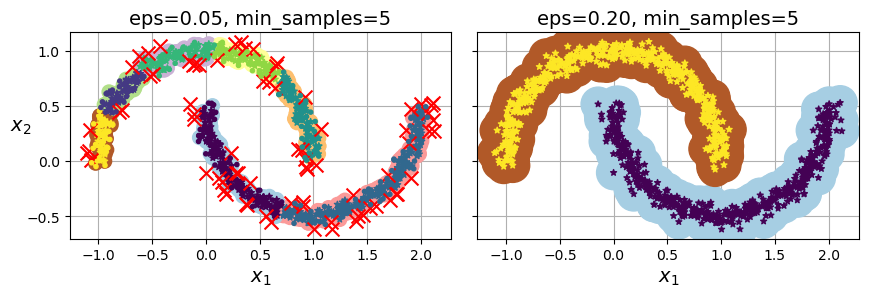

In [87]:
# extra code – this cell generates and saves Figure 9–14

#Esta función plot_dbscan -> representa gráficamente cómo DBSCAN clasifica los puntos según su densidad — mostrando núcleos, puntos de frontera y anomalías con distintos colores y marcadores.

def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    #np.zeros_like(a, dtype=None) ->crea un nuevo array lleno de ceros, que tiene la misma forma y tipo que otro array (a). con dtype=bool covierte los ceros en False
    
    core_mask[dbscan.core_sample_indices_] = True
    #Esto cambia a True solo en las posiciones que corresponden a los puntos centrales (core samples).
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask) # marca todos los puntos que NO son núcleo o ruido.
    # ~(...) → Negación lógica

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")

    #c=dbscan.labels_[core_mask] -> Color de cada punto, según su etiqueta de clúster
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    # las anomalías en color rojo
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

In [88]:
dbscan = dbscan2  # extra code – the text says we now use eps=0.2

In [89]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

,n_neighbors,50
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [90]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [91]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

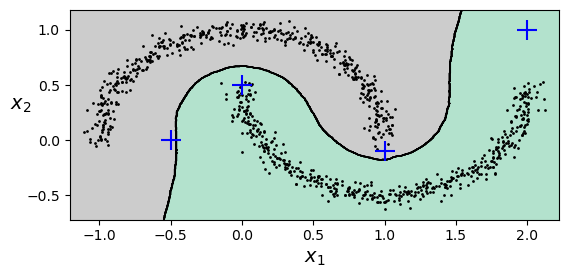

In [92]:
# extra code – this cell generates and saves Figure 9–15

plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [93]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Other Clustering Algorithms

The code in this section is bonus material, not in the book.

### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

In [ ]:
sc1.affinity_matrix_.round(2)

In [ ]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

In [ ]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True,
                             show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"RBF gamma={sc.gamma}")

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [ ]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [ ]:
learned_parameters(agg)

In [ ]:
agg.children_

# Gaussian Mixtures

Let's generate the same dataset as earliers with three ellipsoids (the one K-Means had trouble with):

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

Let's look at the parameters that the EM algorithm estimated:

In [ ]:
gm.weights_

In [ ]:
gm.means_

In [ ]:
gm.covariances_

Did the algorithm actually converge?

In [ ]:
gm.converged_

Yes, good. How many iterations did it take?

In [ ]:
gm.n_iter_

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [ ]:
gm.predict(X)

In [ ]:
gm.predict_proba(X).round(3)

This is a generative model, so you can sample new instances from it (and get their labels):

In [ ]:
X_new, y_new = gm.sample(6)
X_new

In [ ]:
y_new

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [ ]:
gm.score_samples(X).round(2)

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [ ]:
# extra code – bonus material

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [ ]:
# extra code – this cells generates and saves Figure 9–16

from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.

In [ ]:
# extra code – this cell generates and saves Figure 9–17

gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

In [ ]:
# extra code – comparing covariance_type="full" and covariance_type="diag"
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection Using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 2%, then you can set the density threshold to be the value that results in having 2% of the instances located in areas below that threshold density:

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

In [ ]:
# extra code – this cell generates and saves Figure 9–18

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## Selecting the Number of Clusters

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [ ]:
# extra code – this cell generates and saves Figure 9–19

from scipy.stats import norm

x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

xs = np.linspace(x_range[0], x_range[1], 501)
stds = np.linspace(stds_range[0], stds_range[1], 501)
Xs, Stds = np.meshgrid(xs, stds)
Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
Z = Z / Z.sum(axis=1)[:, np.newaxis] / (xs[1] - xs[0])

x_example_idx = (xs >= x_val).argmax()  # index of the first value >= x_val
max_idx = Z[:, x_example_idx].argmax()
max_val = Z[:, x_example_idx].max()
s_example_idx = (stds >= std_val).argmax()
x_range_min_idx = (xs >= x_proba_range[0]).argmax()
x_range_max_idx = (xs >= x_proba_range[1]).argmax()
log_max_idx = np.log(Z[:, x_example_idx]).argmax()
log_max_val = np.log(Z[:, x_example_idx]).max()

plt.figure(figsize=(8, 4.5))

plt.subplot(2, 2, 1)
plt.contourf(Xs, Stds, Z, cmap="GnBu")
plt.plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
plt.plot([x_val, x_val], [1, 2], "b-", linewidth=2)
plt.ylabel(r"$\theta$", rotation=0, labelpad=10)
plt.title(r"Model $f(x; \theta)$")

plt.subplot(2, 2, 2)
plt.plot(stds, Z[:, x_example_idx], "b-")
plt.plot(stds[max_idx], max_val, "r.")
plt.plot([stds[max_idx], stds[max_idx]], [0, max_val], "r:")
plt.plot([0, stds[max_idx]], [max_val, max_val], "r:")
plt.text(stds[max_idx]+ 0.01, 0.081, r"$\hat{\theta}$")
plt.text(stds[max_idx]+ 0.01, max_val - 0.006, r"$Max$")
plt.text(1.01, max_val - 0.008, r"$\hat{\mathcal{L}}$")
plt.ylabel(r"$\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\mathcal{{L}}(\theta|x={x_val}) = f(x={x_val}; \theta)$")
plt.grid()
plt.axis([1, 2, 0.08, 0.12])

plt.subplot(2, 2, 3)
plt.plot(xs, Z[s_example_idx], "k-")
plt.fill_between(xs[x_range_min_idx:x_range_max_idx+1],
                 Z[s_example_idx, x_range_min_idx:x_range_max_idx+1], alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(fr"PDF $f(x; \theta={std_val})$")
plt.grid()
plt.axis([-6, 4, 0, 0.25])

plt.subplot(2, 2, 4)
plt.plot(stds, np.log(Z[:, x_example_idx]), "b-")
plt.plot(stds[log_max_idx], log_max_val, "r.")
plt.plot([stds[log_max_idx], stds[log_max_idx]], [-5, log_max_val], "r:")
plt.plot([0, stds[log_max_idx]], [log_max_val, log_max_val], "r:")
plt.text(stds[log_max_idx]+ 0.01, log_max_val - 0.06, r"$Max$")
plt.text(stds[log_max_idx]+ 0.01, -2.49, r"$\hat{\theta}$")
plt.text(1.01, log_max_val - 0.08, r"$\log \, \hat{\mathcal{L}}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\log \, \mathcal{{L}}(\theta|x={x_val})$")
plt.grid()
plt.axis([1, 2, -2.5, -2.1])

save_fig("likelihood_function_plot")
plt.show()

In [ ]:
gm.bic(X)

In [ ]:
gm.aic(X)

We could compute the BIC manually like this:

In [ ]:
# extra code – bonus material
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood
print(f"bic = {bic}")
print(f"aic = {aic}")
print(f"n_params = {n_params}")

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [ ]:
# extra code – this cell generates and saves Figure 9–20

gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()
save_fig("aic_bic_vs_k_plot")
plt.show()

## Bayesian Gaussian Mixture Models

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

The algorithm automatically detected that only 3 components are needed!

In [ ]:
# extra code – this figure is almost identical to Figure 9–16
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [ ]:
# extra code – this cell generates and saves Figure 9–21

X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid()

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Oops, not great... instead of detecting 2 moon-shaped clusters, the algorithm detected 8 ellipsoidal clusters. However, the density plot does not look too bad, so it might be usable for anomaly detection.

# Exercise solutions

## 1. to 9.

1. In Machine Learning, clustering is the unsupervised task of grouping similar instances together. The notion of similarity depends on the task at hand: for example, in some cases two nearby instances will be considered similar, while in others similar instances may be far apart as long as they belong to the same densely packed group. Popular clustering algorithms include K-Means, DBSCAN, agglomerative clustering, BIRCH, Mean-Shift, affinity propagation, and spectral :.
2. The main applications of clustering algorithms include data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, anomaly detection, and novelty detection.
3. The elbow rule is a simple technique to select the number of clusters when using K-Means: just plot the inertia (the mean squared distance from each instance to its nearest centroid) as a function of the number of clusters, and find the point in the curve where the inertia stops dropping fast (the "elbow"). This is generally close to the optimal number of clusters. Another approach is to plot the silhouette score as a function of the number of clusters. There will often be a peak, and the optimal number of clusters is generally nearby. The silhouette score is the mean silhouette coefficient over all instances. This coefficient varies from +1 for instances that are well inside their cluster and far from other clusters, to –1 for instances that are very close to another cluster. You may also plot the silhouette diagrams and perform a more thorough analysis.
4. Labeling a dataset is costly and time-consuming. Therefore, it is common to have plenty of unlabeled instances, but few labeled instances. Label propagation is a technique that consists in copying some (or all) of the labels from the labeled instances to similar unlabeled instances. This can greatly extend the number of labeled instances, and thereby allow a supervised algorithm to reach better performance (this is a form of semi-supervised learning). One approach is to use a clustering algorithm such as K-Means on all the instances, then for each cluster find the most common label or the label of the most representative instance (i.e., the one closest to the centroid) and propagate it to the unlabeled instances in the same cluster.
5. K-Means and BIRCH scale well to large datasets. DBSCAN and Mean-Shift look for regions of high density.
6. Active learning is useful whenever you have plenty of unlabeled instances but labeling is costly. In this case (which is very common), rather than randomly selecting instances to label, it is often preferable to perform active learning, where human experts interact with the learning algorithm, providing labels for specific instances when the algorithm requests them. A common approach is uncertainty sampling (see the _Active Learning_ section in chapter 9).
7. Many people use the terms _anomaly detection_ and _novelty detection_ interchangeably, but they are not exactly the same. In anomaly detection, the algorithm is trained on a dataset that may contain outliers, and the goal is typically to identify these outliers (within the training set), as well as outliers among new instances. In novelty detection, the algorithm is trained on a dataset that is presumed to be "clean," and the objective is to detect novelties strictly among new instances. Some algorithms work best for anomaly detection (e.g., Isolation Forest), while others are better suited for novelty detection (e.g., one-class SVM).
8. A Gaussian mixture model (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. In other words, the assumption is that the data is grouped into a finite number of clusters, each with an ellipsoidal shape (but the clusters may have different ellipsoidal shapes, sizes, orientations, and densities), and we don't know which cluster each instance belongs to. This model is useful for density estimation, clustering, and anomaly detection.
9. One way to find the right number of clusters when using a Gaussian mixture model is to plot the Bayesian information criterion (BIC) or the Akaike information criterion (AIC) as a function of the number of clusters, then choose the number of clusters that minimizes the BIC or AIC. Another technique is to use a Bayesian Gaussian mixture model, which automatically selects the number of clusters.

## 10. Cluster the Olivetti Faces Dataset

*Exercise: The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function.*

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [ ]:
print(olivetti.DESCR)

In [ ]:
olivetti.target

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data,
                                                   olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

To speed things up, we'll reduce the data's dimensionality using PCA:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print(f"k={k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

In [ ]:
best_k

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.plot(best_k, best_inertia, "rs")
plt.grid()
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=120.

In [ ]:
best_model = kmeans_per_k[best_index]

*Exercise: Visualize the clusters: do you see similar faces in each cluster?*

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## 11. Using Clustering as Preprocessing for Classification

*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

*Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.*

In [ ]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [ ]:
from sklearn.pipeline import make_pipeline

for n_clusters in k_range:
    pipeline = make_pipeline(
        KMeans(n_clusters=n_clusters, n_init=10, random_state=42),
        RandomForestClassifier(n_estimators=150, random_state=42)
    )
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [ ]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [ ]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

## 12. A Gaussian Mixture Model for the Olivetti Faces Dataset

*Exercise: Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).*

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [ ]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

In [ ]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

In [ ]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [ ]:
gm.score_samples(X_bad_faces_pca)

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [ ]:
gm.score_samples(X_train_pca[:10])

## 13. Using Dimensionality Reduction Techniques for Anomaly Detection

*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [ ]:
X_train_pca.round(2)

In [ ]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [ ]:
reconstruction_errors(pca, X_train).mean()

In [ ]:
reconstruction_errors(pca, X_bad_faces).mean()

In [ ]:
plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)